## MNE Tutorial

### Adult template MRI

In [1]:
# # Authors: Alexandre Gramfort <alexandre.gramfort@inria.fr>
# #          Joan Massich <mailsik@gmail.com>
# #          Eric Larson <larson.eric.d@gmail.com>
# #
# # License: BSD-3-Clause
# # Copyright the MNE-Python contributors.

# import numpy as np

# import mne
# from mne.datasets import eegbci, fetch_fsaverage

# # Download fsaverage files
# fs_dir = fetch_fsaverage(verbose=True)
# subjects_dir = fs_dir.parent

# # The files live in:
# subject = "fsaverage"
# trans = "fsaverage"  # MNE has a built-in fsaverage transformation
# src = fs_dir / "bem" / "fsaverage-ico-5-src.fif"
# bem = fs_dir / "bem" / "fsaverage-5120-5120-5120-bem-sol.fif"

### Load Data

In [2]:
# (raw_fname,) = eegbci.load_data(subject=1, runs=[6])
# raw = mne.io.read_raw_edf(raw_fname, preload=True)

# # Clean channel names to be able to use a standard 1005 montage
# new_names = dict(
#     (ch_name, ch_name.rstrip(".").upper().replace("Z", "z").replace("FP", "Fp"))
#     for ch_name in raw.ch_names
# )
# raw.rename_channels(new_names)

# # Read and set the EEG electrode locations, which are already in fsaverage's
# # space (MNI space) for standard_1020:
# montage = mne.channels.make_standard_montage("standard_1005")
# raw.set_montage(montage)
# raw.set_eeg_reference(projection=True)  # needed for inverse modeling

# # Check that the locations of EEG electrodes is correct with respect to MRI
# mne.viz.plot_alignment(
#     raw.info,
#     src=src,
#     eeg=["original", "projected"],
#     trans=trans,
#     show_axes=True,
#     mri_fiducials=True,
#     dig="fiducials",
# )

## Simulation

In [3]:
import numpy as np

import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse, read_inverse_operator
from mne.simulation import simulate_evoked, simulate_stc

In [4]:
seed = 42

# parameters for inverse method
method = "sLORETA"
snr = 3.0
lambda2 = 1.0 / snr**2

# signal simulation parameters
# do not add extra noise to the known signals
nave = np.inf
T = 100
times = np.linspace(0, 1, T)
dt = times[1] - times[0]

# Paths to MEG data
data_path = sample.data_path()
subjects_dir = data_path / "subjects"
fname_fwd = data_path / "MEG" / "sample" / "sample_audvis-eeg-oct-6-fwd.fif"
fname_inv = data_path / "MEG" / "sample" / "sample_audvis-eeg-oct-6-eeg-inv.fif"
# fname_fwd = data_path / "MEG" / "sample" / "sample_audvis-meg-oct-6-fwd.fif"
# fname_inv = data_path / "MEG" / "sample" / "sample_audvis-meg-oct-6-meg-fixed-inv.fif"
fname_evoked = data_path / "MEG" / "sample" / "sample_audvis-ave.fif"

### Setup

In [5]:
fwd = mne.read_forward_solution(fname_fwd)
fwd = mne.convert_forward_solution(fwd, force_fixed=False, surf_ori=True, copy=False)
fwd["info"]["bads"] = []
inv_op = read_inverse_operator(fname_inv)

raw = mne.io.read_raw_fif(data_path / "MEG" / "sample" / "sample_audvis_raw.fif")
raw.info["bads"] = []
raw.set_eeg_reference(projection=True)
events = mne.find_events(raw)
event_dict = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
}
epochs = mne.Epochs(raw, events, event_dict, baseline=(None, 0), preload=True)
evoked = epochs.average()

labels = mne.read_labels_from_annot("sample", subjects_dir=subjects_dir)
label_names = [label.name for label in labels]
n_labels = len(labels)

Reading forward solution from C:\Users\richi\mne_data\MNE-sample-data\MEG\sample\sample_audvis-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Reading inverse operator decomposition from C:\Users\richi\mne_data\MNE-sample-data\MEG\sample\sample_audvis-eeg-oct-6-eeg-inv.fif...
    Reading inverse operator info...
    [done]
 

In [6]:
cov = mne.compute_covariance(epochs, tmin=None, tmax=0.0)

    Created an SSP operator (subspace dimension = 4)
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 366 -> 362
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 34969
[done]


In [7]:
label_names

['bankssts-lh',
 'bankssts-rh',
 'caudalanteriorcingulate-lh',
 'caudalanteriorcingulate-rh',
 'caudalmiddlefrontal-lh',
 'caudalmiddlefrontal-rh',
 'cuneus-lh',
 'cuneus-rh',
 'entorhinal-lh',
 'entorhinal-rh',
 'frontalpole-lh',
 'frontalpole-rh',
 'fusiform-lh',
 'fusiform-rh',
 'inferiorparietal-lh',
 'inferiorparietal-rh',
 'inferiortemporal-lh',
 'inferiortemporal-rh',
 'insula-lh',
 'insula-rh',
 'isthmuscingulate-lh',
 'isthmuscingulate-rh',
 'lateraloccipital-lh',
 'lateraloccipital-rh',
 'lateralorbitofrontal-lh',
 'lateralorbitofrontal-rh',
 'lingual-lh',
 'lingual-rh',
 'medialorbitofrontal-lh',
 'medialorbitofrontal-rh',
 'middletemporal-lh',
 'middletemporal-rh',
 'paracentral-lh',
 'paracentral-rh',
 'parahippocampal-lh',
 'parahippocampal-rh',
 'parsopercularis-lh',
 'parsopercularis-rh',
 'parsorbitalis-lh',
 'parsorbitalis-rh',
 'parstriangularis-lh',
 'parstriangularis-rh',
 'pericalcarine-lh',
 'pericalcarine-rh',
 'postcentral-lh',
 'postcentral-rh',
 'posteriorcin

In [8]:
# The known signal is all zero-s off of the two labels of interest
signal = np.zeros((n_labels, T))
print(signal.shape)
idx = label_names.index("inferiorparietal-lh")
print(idx)
signal[idx, :] = 1e-7 * np.sin(5 * 2 * np.pi * times)
idx = label_names.index("lateraloccipital-lh")
print(idx)
signal[idx, :] = 1e-7 * np.sin(16 * 2 * np.pi * times)

(68, 100)
14
22


### Mask the Labels vertices from central n_labels

In [26]:
fwd["src"][hemi_to_ind[label.hemi]]

{'id': 102,
 'type': 'surf',
 'np': 156866,
 'ntri': 313728,
 'coord_frame': 4,
 'rr': array([[ 0.01348992, -0.05774378,  0.08630154],
        [ 0.01312197, -0.0577858 ,  0.08628145],
        [ 0.01230842, -0.05809817,  0.08590845],
        ...,
        [ 0.01687537,  0.09684894,  0.03134464],
        [ 0.01818678,  0.09652486,  0.03175054],
        [ 0.01763045,  0.09674414,  0.03164404]]),
 'nn': array([[ 0.18669518, -0.59453485,  0.78209566],
        [ 0.00813681, -0.63648817,  0.77124384],
        [-0.08722755, -0.71909727,  0.68941336],
        ...,
        [ 0.22914861,  0.66701178, -0.70893349],
        [ 0.25632719, -0.11043257, -0.96026096],
        [ 0.36076548,  0.47237827, -0.80418107]]),
 'tris': array([[     0,      1,      5],
        [     6,      5,      1],
        [     0,     89,      1],
        ...,
        [155499, 155850, 155706],
        [155294, 155505, 155293],
        [155505, 155292, 155293]]),
 'nuse': 3766,
 'inuse': array([0, 0, 0, ..., 0, 0, 0], dtype=i

In [9]:
hemi_to_ind = {"lh": 0, "rh": 1}
for i, label in enumerate(labels):
    # The `center_of_mass` function needs labels to have values.
    labels[i].values.fill(1.0)

    # Restrict the eligible vertices to be those on the surface under
    # consideration and within the label.
    surf_vertices = fwd["src"][hemi_to_ind[label.hemi]]["vertno"]
    restrict_verts = np.intersect1d(surf_vertices, label.vertices)
    com = labels[i].center_of_mass(
        subjects_dir=subjects_dir, restrict_vertices=restrict_verts, surf="white"
    )

    # Convert the center of vertex index from surface vertex list to Label's
    # vertex list.
    cent_idx = np.where(label.vertices == com)[0][0]

    # Create a mask with 1 at center vertex and zeros elsewhere.
    labels[i].values.fill(0.0)
    labels[i].values[cent_idx] = 1.0

    # Print some useful information about this vertex and label
    if "transversetemporal" in label.name:
        dist, _ = label.distances_to_outside(subjects_dir=subjects_dir)
        dist = dist[cent_idx]
        area = label.compute_area(subjects_dir=subjects_dir)
        # convert to equivalent circular radius
        r = np.sqrt(area / np.pi)
        print(
            f"{label.name} COM vertex is {dist * 1e3:0.1f} mm from edge "
            f"(label area equivalent to a circle with r={r * 1e3:0.1f} mm)"
        )

    Triangle neighbors and vertex normals...
transversetemporal-lh COM vertex is 7.5 mm from edge (label area equivalent to a circle with r=11.5 mm)
    Triangle neighbors and vertex normals...
transversetemporal-rh COM vertex is 6.8 mm from edge (label area equivalent to a circle with r=10.8 mm)


##### Create source-space data with known signals
- Put known signals onto surface vertices using the array of signals and the label masks (stored in labels[i].values).

In [10]:
stc_gen = simulate_stc(fwd["src"], labels, signal, times[0], dt, value_fun=lambda x: x)

In [11]:
stc_gen

<SourceEstimate | 6940 vertices, subject : sample, tmin : 0.0 (ms), tmax : 1000.0 (ms), tstep : 10.101010101010102 (ms), data shape : (6940, 100), ~5.3 MB>

### Plot Simulate Source 

Using notebook 3d backend.


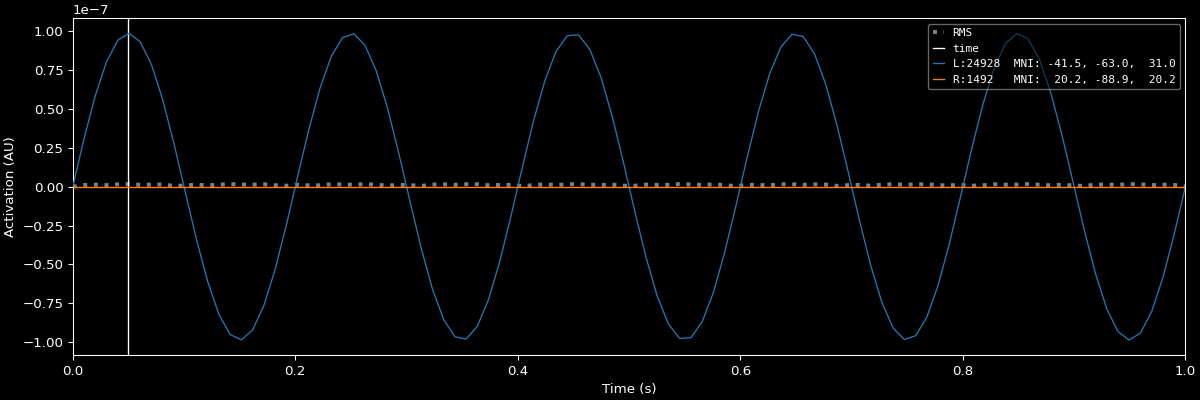

In [12]:
kwargs = dict(
    subjects_dir=subjects_dir,
    hemi="split",
    smoothing_steps=4,
    time_unit="s",
    initial_time=0.05,
    size=1200,
    views=["lat", "med"],
)
clim = dict(kind="value", pos_lims=[1e-9, 1e-8, 1e-7])
brain_gen = stc_gen.plot(clim=clim, **kwargs)

### Do Fwd and Inv

In [13]:
# fwd: Forward source course to sensor-space
# stc_gen
evoked_gen = simulate_evoked(fwd, stc_gen, evoked.info, cov, nave, random_state=seed)

# Map the simulated sensor-space data to source-space using the inverse
# operator.
stc_inv = apply_inverse(evoked_gen, inv_op, lambda2, method="eLORETA", pick_ori="normal")



    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Projecting source estimate to sensor space...
[done]
4 projection items deactivated
Created an SSP operator (subspace dimension = 1)
4 projection items activated
SSP projectors applied...
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 58 (1 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 12 (4.4e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Applying inverse operator to ""...
    Picked 59 channels from the data
    Co

### Plot Inverse Brain Source 

Using control points [1.33703753e-10 1.71092320e-10 4.52290772e-10]


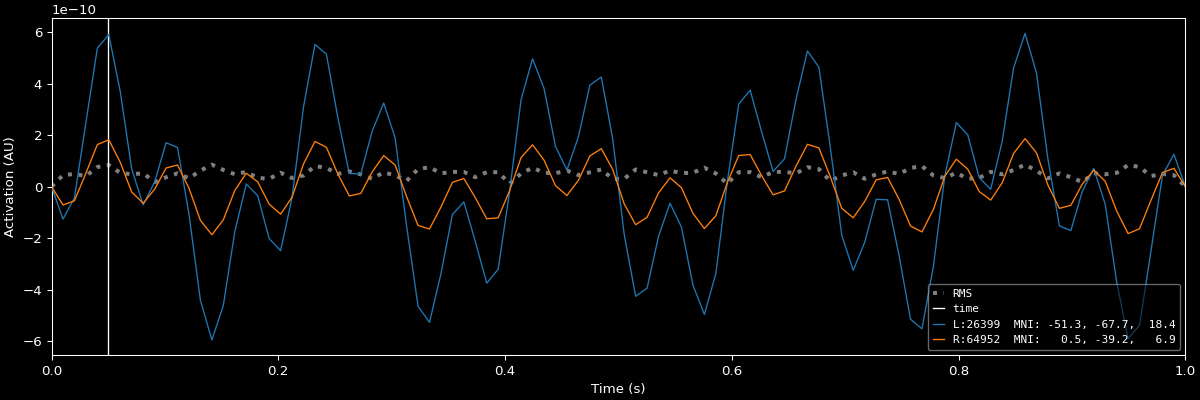

In [14]:
brain_inv = stc_inv.plot(**kwargs)

### Plot EEG Simulate

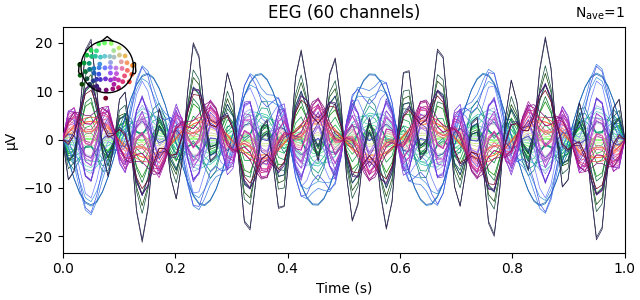

<Figure size 640x300 with 2 Axes>

In [15]:
# print(stc_inv.data)
# 確認 stc_inv.data 是否存在
# if hasattr(evoked_gen, 'data'):
#     # 找出負值的總數
#     num_negative_values = (evoked_gen.data < 0).sum()

#     # 打印結果
#     print(f"Number of negative values in stc_inv.data: {num_negative_values}")
# else:
#     print("stc_inv does not have an attribute 'data'")

evoked_gen.plot()

In [16]:
# evoked_gen
print(stc_inv)
print(inv_op)

<SourceEstimate | 7498 vertices, subject : sample, tmin : 0.0 (ms), tmax : 1000.0 (ms), tstep : 10.101010101010102 (ms), data shape : (7498, 100), ~5.8 MB>
<InverseOperator | MEG channels: 0 | EEG channels: 59 | Source space: surface with 7498 sources | Source orientation: Loose (0.20000000298023224)>


### PCA 

In [17]:
import numpy as np
import mne
from sklearn.decomposition import PCA

# 取得 stc_gen 內的數據 (6940, 100)
stc_data = stc_inv.data  # shape: (6940, 100)

# 初始化 PCA
pca = PCA(n_components=1)  # 取前 3 個主成分

# 儲存降維後的信號
pca_time_series = []

# 針對每個 label 進行 PCA
for label in labels:
    # 獲取當前 label 內的頂點索引
    label_vertices = np.intersect1d(label.vertices, np.concatenate(stc_gen.vertices))

    # 若 label 內沒有任何有效頂點，跳過
    print(label)
    if len(label_vertices) == 0:
        pca_time_series.append(np.zeros((3, 100)))  # 空的填充
        continue

    # 找出 stc_gen 內對應的 index
    label_idx = np.where(np.isin(np.concatenate(stc_gen.vertices), label_vertices))[0]

    # 取出該 label 內的 source time courses
    label_data = stc_data[label_idx, :]  # shape: (N_label_vertices, 100)

    # 使用 PCA 進行降維，取前 3 個主成分
    pca_result = pca.fit_transform(label_data.T).T  # shape: (3, 100)

    # 存入結果
    pca_time_series.append(pca_result)

# 轉換成 NumPy 陣列
pca_time_series = np.vstack(pca_time_series)  # shape: (68×3, 100)

# 輸出最終形狀
pca_time_series.shape  # 期望結果: (68*3, 100)


<Label | sample, 'bankssts-lh', lh : 1604 vertices>
<Label | sample, 'bankssts-rh', rh : 1555 vertices>
<Label | sample, 'caudalanteriorcingulate-lh', lh : 1277 vertices>
<Label | sample, 'caudalanteriorcingulate-rh', rh : 1982 vertices>
<Label | sample, 'caudalmiddlefrontal-lh', lh : 3810 vertices>
<Label | sample, 'caudalmiddlefrontal-rh', rh : 3994 vertices>
<Label | sample, 'cuneus-lh', lh : 2545 vertices>
<Label | sample, 'cuneus-rh', rh : 2479 vertices>
<Label | sample, 'entorhinal-lh', lh : 726 vertices>
<Label | sample, 'entorhinal-rh', rh : 571 vertices>
<Label | sample, 'frontalpole-lh', lh : 350 vertices>
<Label | sample, 'frontalpole-rh', rh : 483 vertices>
<Label | sample, 'fusiform-lh', lh : 5209 vertices>
<Label | sample, 'fusiform-rh', rh : 4843 vertices>
<Label | sample, 'inferiorparietal-lh', lh : 7839 vertices>
<Label | sample, 'inferiorparietal-rh', rh : 8562 vertices>
<Label | sample, 'inferiortemporal-lh', lh : 6363 vertices>
<Label | sample, 'inferiortemporal-rh'

(68, 100)

### FFT

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# 假設你的降維數據是 (68, 100)，這裡用隨機數據替代
source_data = pca_time_series

# 設定 FFT 參數
sampling_rate = 100  # 假設取樣率為 100 Hz

# 計算 FFT
fft_result = np.fft.fft(source_data, axis=1)
power_spectrum = np.abs(fft_result) ** 2

# 計算頻率軸
freqs = np.fft.fftfreq(source_data.shape[1], d=1/sampling_rate)

# 只取正頻率部分
positive_freqs = freqs[:source_data.shape[1] // 2]
positive_power = power_spectrum[:, :source_data.shape[1] // 2]



### Plot FFT

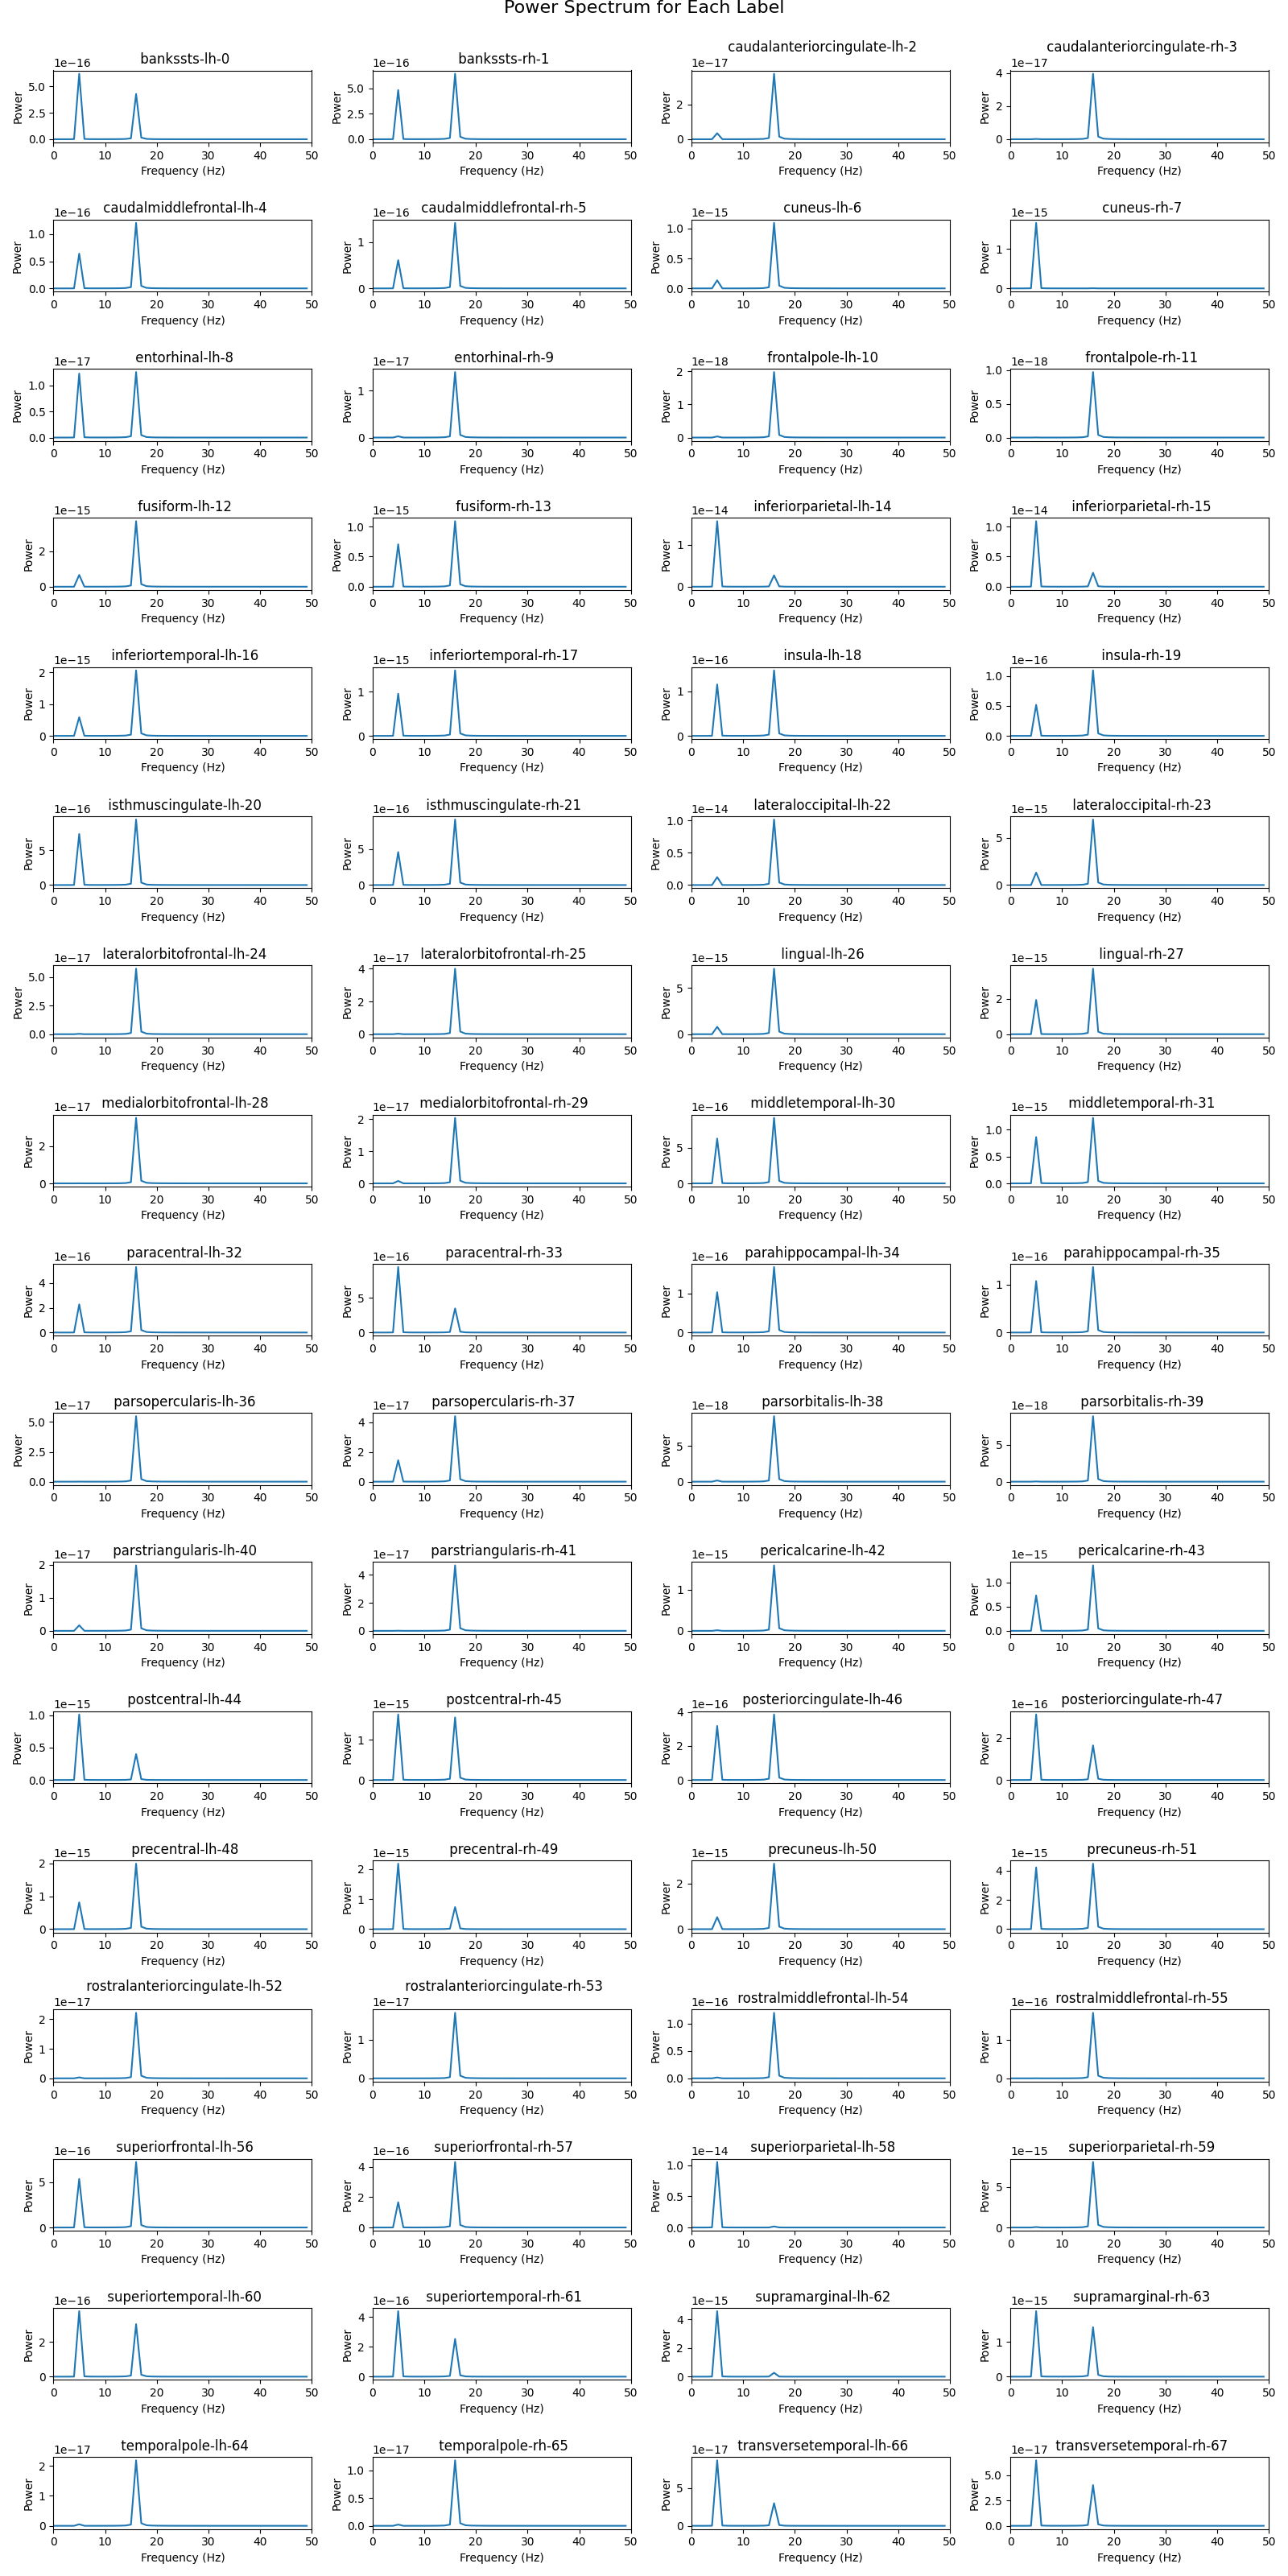

In [19]:
# 畫出所有 labels 的 Power Spectrum
fig, axes = plt.subplots(17, 4, figsize=(16, 32))  # 8x9 網格排布 (68 個 labels)
fig.suptitle("Power Spectrum for Each Label", fontsize=16, y=1)

for i, ax in enumerate(axes.flat):
    if i < 68:
        ax.plot(positive_freqs, positive_power[i], label=f'Label {i+1}')
        ax.set_title(f' {labels[i].name}-{i}')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Power')
        ax.set_xlim([0, sampling_rate / 2])  # Nyquist 頻率範圍
    else:
        ax.axis("off")  # 超出 68 個 labels 的 subplot 關閉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

plt.tight_layout(rect=[0, 0, 1, 1])  # 調整間距，避免標題擠壓圖像
plt.show()
